In [31]:
import gc
import cudf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
# using giba's dataset since it's already in parquet format
# Dataset: https://www.kaggle.com/datasets/titericz/leap-dataset-giba
# This dataset was created using all train and test data.
# Train is 10M samples and was split in 17 parquet files. Test is a single parquet file.
data_path = "/kaggle/input/leap-dataset-giba/"  # ./data
train_files = sorted(glob(f"{data_path}/train_batch/*.parquet"))
test_files = glob(f"{data_path}/test_batch/*.parquet")

In [3]:
# Train on 1/8 of the full dataset
train = pd.read_parquet(train_files[:1]).astype('float32')
#train = cudf.from_pandas(train)
#gc.collect()

# Validate on last parquet file (625000 samples)
valid = pd.read_parquet(train_files[-1]).astype('float32')
#valid = cudf.from_pandas(valid) # Send to GPU for speedup
#gc.collect()

test  = pd.read_parquet(test_files[0]).astype('float32')
#test = cudf.from_pandas(test) # Send to GPU for speedup
#gc.collect()

train.shape, valid.shape, test.shape

((625000, 793), (625000, 793), (625000, 491))

In [4]:
test.head()

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,pbuf_N2O_17,pbuf_N2O_18,pbuf_N2O_19,pbuf_N2O_20,pbuf_N2O_21,pbuf_N2O_22,pbuf_N2O_23,pbuf_N2O_24,pbuf_N2O_25,pbuf_N2O_26
0,169651.0,209.802597,220.698212,227.783295,241.386810,254.602966,262.319061,261.308380,254.062027,243.904419,...,3.892490e-07,4.180467e-07,4.462546e-07,4.738700e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
1,524862.0,208.366104,219.238708,228.265015,242.099777,256.164276,263.783203,261.835388,253.636169,243.783463,...,3.799159e-07,4.083217e-07,4.361652e-07,4.634412e-07,4.901268e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
2,634129.0,213.073776,229.421555,233.368454,242.683792,252.912781,260.953979,260.977325,253.059891,240.929886,...,4.160912e-07,4.459261e-07,4.750905e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
3,403572.0,212.048630,226.003860,230.980606,241.056183,252.829636,262.185760,261.900757,253.187195,241.186310,...,4.090177e-07,4.385979e-07,4.675294e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
4,484578.0,207.926102,216.697342,227.821594,243.555008,257.498535,265.294250,262.886902,253.702133,243.453690,...,3.739503e-07,4.021011e-07,4.297071e-07,4.567618e-07,4.832411e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07


# Utils

In [5]:
# because python doesn't have a builtin flatmap for some reason
def flatmap(func, iterables):
    return [item for iter in iterables for item in func(iter)]


target_scalars = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]

target_vectors_base = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]


def concat60(base):
    return [f"{base}_{i}" for i in range(60)]


# concat the 60 levels
target_vectors = flatmap(concat60, target_vectors_base)

target_cols = target_scalars + target_vectors


feat_scalars = [
    "state_ps",
    "pbuf_SOLIN",
    "pbuf_LHFLX",
    "pbuf_SHFLX",
    "pbuf_TAUX",
    "pbuf_TAUY",
    "pbuf_COSZRS",
    "cam_in_ALDIF",
    "cam_in_ALDIR",
    "cam_in_ASDIF",
    "cam_in_ASDIR",
    "cam_in_LWUP",
    "cam_in_ICEFRAC",
    "cam_in_LANDFRAC",
    "cam_in_OCNFRAC",
    "cam_in_SNOWHLAND",
]


feat_vectors_base = [
    "state_t",
    "state_q0001",
    "state_q0002",
    "state_q0003",
    "state_u",
    "state_v",
    "pbuf_ozone",
    "pbuf_CH4",
    "pbuf_N2O",
]

feat_vectors = flatmap(concat60, feat_vectors_base)

feat_cols = feat_scalars + feat_vectors

# Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional import r2_score as r2_loss

## Data processing

In [7]:
filtered_feat_cols = [col for col in feat_cols if col in train.columns]
filtered_target_cols = [col for col in target_cols if col in train.columns]

for i, n in enumerate([filtered_feat_cols, filtered_target_cols]):
    f = [feat_cols, target_cols][i]
    missing_cols = [col for col in f if col not in filtered_target_cols]
    #print(f"Warning: Columns {missing_cols} not found in the data")
    print(f"Using only {len(n)} columns out of {len(f)}")

Using only 490 columns out of 556
Using only 302 columns out of 368


In [8]:
# giba's dataset has dropped some columns, so we need to filter them out
def get_input_data(data, is_feat=True):
    f = filtered_feat_cols if is_feat else filtered_target_cols
    return data[f].values


X_train = get_input_data(train, True)
y_train = get_input_data(train, False)
X_valid = get_input_data(valid, True)
y_valid = get_input_data(valid, False)

## Training loop

### GPU setup

In [9]:
if torch.cuda.is_available():
    print("GPU available")
    device = torch.device("cuda")  # Use GPU
else:
    print("GPU not available")
    device = torch.device("cpu")

GPU available


In [10]:
# tensors for convenience
X_train_tensor = torch.tensor(X_train)#.to(device)
y_train_tensor = torch.tensor(y_train)#.to(device)
X_valid_tensor = torch.tensor(X_valid)#.to(device)
y_valid_tensor = torch.tensor(y_valid)#.to(device)

input_size = X_train.shape[1]  # len(feat_cols)  # number of input features
output_size = y_train.shape[1]  # len(target_cols)  # number of output features

In [70]:
class TabularModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularModel, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            #nn.Linear(2048, 2048),
            #nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [72]:
batch_size = 4096
learning_rate = 0.005

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TabularModel(input_size, output_size).to(device)

# loss function and optimizer
criterion = nn.MSELoss()  #r2_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [73]:
num_epochs = 10

# history
train_losses = []
train_r2_scores = []

for epoch in tqdm(range(num_epochs)):
    y_pred = []
    y_true = []
    epoch_losses = []
    
    model.train()
    
    for X_batch, y_batch in dataloader:
        # Move batch to GPU if available
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # r2 loss (higher is better)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()

        optimizer.step()
                
        # save for end of epoch score computation
        y_pred.append(outputs.detach().cpu().numpy())
        y_true.append(y_batch.detach().cpu().numpy())
        epoch_losses.append(loss.item())

    # Compute R2 score
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    train_r2 = r2_score(y_true, y_pred)

    train_r2_scores.append(train_r2)
    loss = np.mean(epoch_losses)
    train_losses.append(loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train R2: {train_r2:.4f}")


 10%|█         | 1/10 [00:28<04:17, 28.59s/it]

Epoch [1/10], Loss: 0.9055, Train R2: -5281592807387226.0000


 20%|██        | 2/10 [00:56<03:46, 28.32s/it]

Epoch [2/10], Loss: 0.8432, Train R2: -99312266509591.2188


 30%|███       | 3/10 [01:25<03:19, 28.43s/it]

Epoch [3/10], Loss: 0.8283, Train R2: -24145718528812.1836


 40%|████      | 4/10 [01:53<02:50, 28.41s/it]

Epoch [4/10], Loss: 0.8187, Train R2: -956179992293.6631


 50%|█████     | 5/10 [02:22<02:22, 28.48s/it]

Epoch [5/10], Loss: 0.8101, Train R2: -17159946659593.2285


 60%|██████    | 6/10 [02:50<01:53, 28.48s/it]

Epoch [6/10], Loss: 0.8030, Train R2: -7465013113386.9209


 70%|███████   | 7/10 [03:19<01:25, 28.48s/it]

Epoch [7/10], Loss: 0.7965, Train R2: -3370500129940.1680


 80%|████████  | 8/10 [03:47<00:56, 28.39s/it]

Epoch [8/10], Loss: 0.7901, Train R2: -105589611.8767


 90%|█████████ | 9/10 [04:15<00:28, 28.27s/it]

Epoch [9/10], Loss: 0.7832, Train R2: -107148729837.8563


100%|██████████| 10/10 [04:43<00:00, 28.35s/it]

Epoch [10/10], Loss: 0.7772, Train R2: -1640385113677.6882


# Prediction

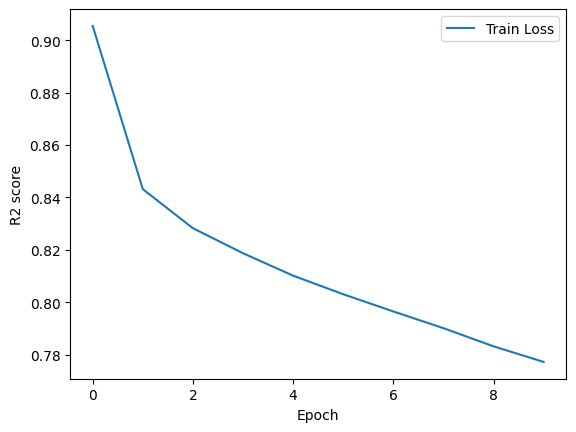

In [74]:
import matplotlib.pyplot as plt

#plt.plot(train_r2_scores, label='Train R2')
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('R2 score')
plt.legend()
plt.show()

# Predict

In [75]:
X_valid = torch.tensor(get_input_data(valid, True)).to(device)
y_valid = torch.tensor(get_input_data(valid, False))

In [76]:
with torch.no_grad():
    valid_preds = model(X_valid).cpu().detach().numpy()
valid_preds = pd.DataFrame(valid_preds, columns=filtered_target_cols)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.77 GiB. GPU 0 has a total capacty of 15.89 GiB of which 3.63 GiB is free. Process 4138 has 12.27 GiB memory in use. Of the allocated memory 5.99 GiB is allocated by PyTorch, and 5.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [64]:
r2_scores = {}
for i, col in tqdm(enumerate(filtered_target_cols)):
    r2_scores[col] = r2_score(y_valid[:, i], valid_preds[col])

302it [00:04, 71.42it/s]


cam_out_NETSW : 0.829979203001004
cam_out_FLWDS : 0.7960259053149745
cam_out_PRECSC : 0.5394420537870737
cam_out_PRECC : 0.609454174557817
cam_out_SOLS : 0.7674898996696469
cam_out_SOLL : 0.754230373939346
cam_out_SOLSD : 0.7646854227340321
cam_out_SOLLD : 0.599858545349516


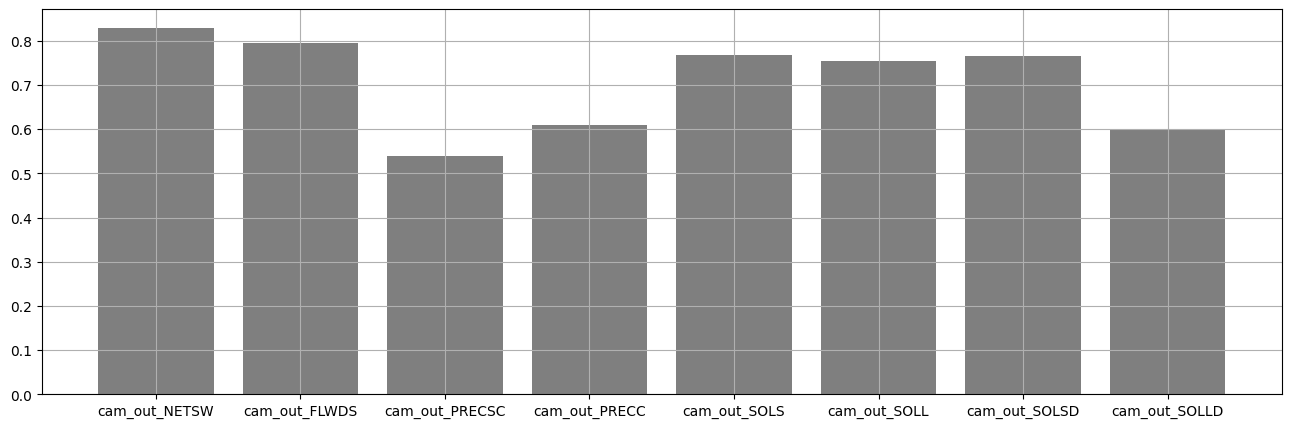

In [65]:
plt.figure(figsize=(16, 5))
plt.grid()
for ft in target_scalars:
    plt.bar(target_scalars, [r2_scores[col] for col in target_scalars])
for col in target_scalars:
    print(f"{col} : {r2_scores[col]}")

In [66]:
ss = pd.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", nrows=1).drop(['sample_id'], axis=1)
ss

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,30981.265272,22502.432414,18894.14713,14514.244731,10944.348069,9065.01072,9663.669039,12688.557363,19890.172265,25831.373172,...,41183.344137,29194.123693,0.004054,0.013882,1.351299e+08,1.221972e+07,0.009071,0.00859,0.021537,0.033632


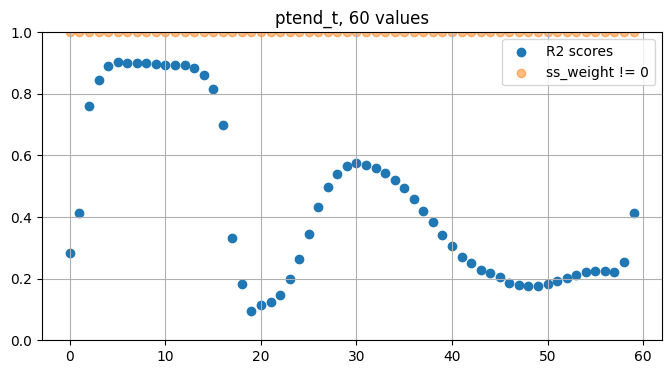

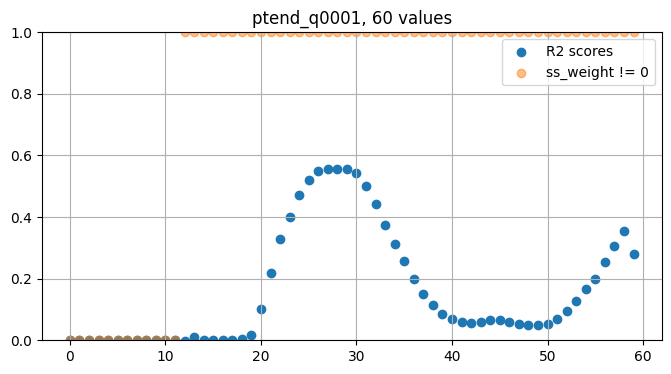

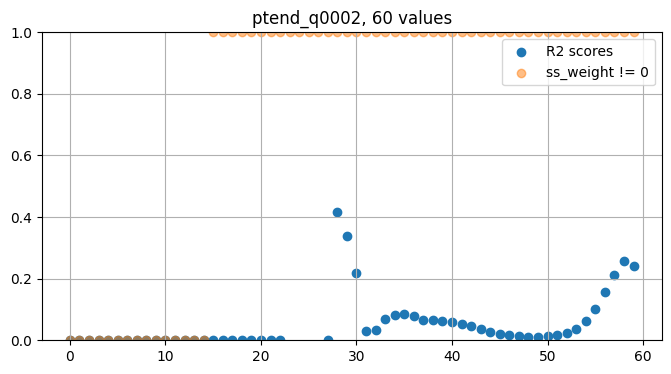

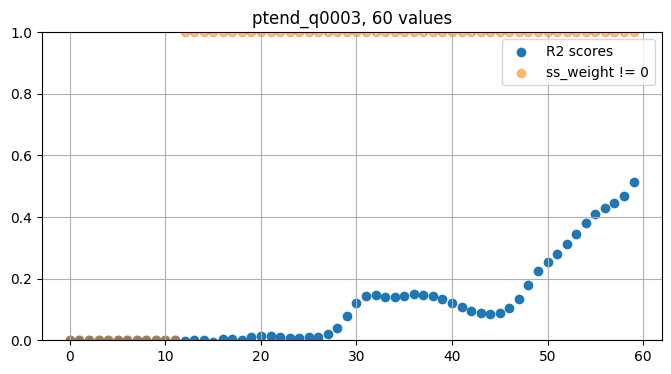

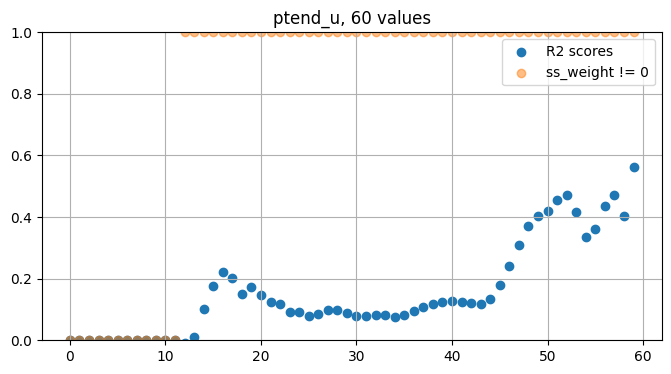

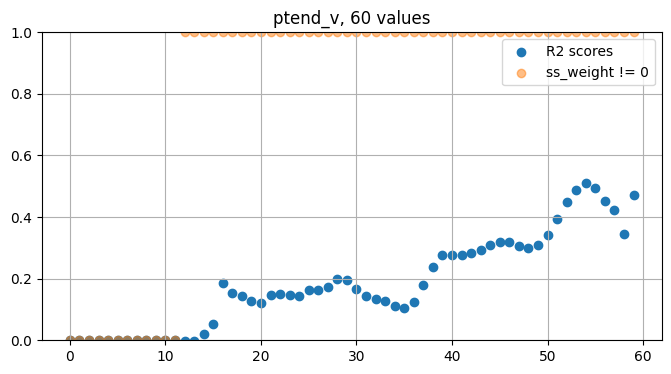

In [67]:
for col in target_vectors_base:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(60), [f"{col}_{i}" in r2_scores and r2_scores[f"{col}_{i}"] or 0 for i in range(60)])
    plt.scatter(range(60), [(ss[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)], alpha=0.5)
    plt.title(f"{col}, 60 values")
    plt.grid()
    plt.legend(["R2 scores", "ss_weight != 0"])
    plt.ylim(0, 1)

# Write submission file

In [68]:
weights = pd.read_csv(f"/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", nrows=1)
weights = weights.drop(['sample_id'], axis=1).T.to_dict()[0]

In [ ]:
set(filtered_target_cols) - set(test_preds.columns)

In [69]:
submission = pd.read_csv(f"/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

for col in tqdm(filtered_target_cols):
    if weights[col] > 0:
        submission[col] = test_preds[col].values
    else:
        submission[col] = 0.
        
submission.to_csv('/kaggle/working/submission.csv', index=False)        
submission.head()

  0%|          | 0/302 [00:00<?, ?it/s]


NameError: name 'test_preds' is not defined